In [1]:
import numpy  as np
import scipy  as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import h5py

%matplotlib inline

## Illustris

http://www.illustris-project.org/data/docs/specifications

Group catalogs (FoF & Subfind)

* Illustris-1 group catalog 135
  * SubhaloMass
  * SubhaloSFR
  * SubhaloStellarPhotometrics

```bash
wget -nd -nc -nv -e robots=off -l 1 -r -A hdf5 --content-disposition --header="API-Key: f118abac20d4f8ffc499766738e770ee" "http://www.illustris-project.org/api/Illustris-1/files/groupcat-135/?format=api" 
```

Supplementary data catalogs

* (b) Photometric non-parametric stellar morphologies
* (c) Stellar circularities, angular momenta, axis ratios

In [2]:
morfologías    = h5py.File('../illustris/nonparametric_morphologies.hdf5', 'r')
circularidades = h5py.File('../illustris/stellar_circs.hdf5', 'r')

filtros = ['gSDSS', 'iSDSS', 'uSDSS', 'hWFC3']
cámaras = ['cam0', 'cam1', 'cam2', 'cam3']

Illustris almacena los datos en archivos HDF5 de una manera muy extraña. Los llevamos a un `DataFrame` para que sean más usables.

In [3]:
m = pd.DataFrame()

for filtro in filtros:
    for cámara in cámaras:
        aux = pd.DataFrame()
        
        aux['id']     = morfologías['Snapshot_135/SubfindID_%s' % cámara]
        aux['filtro'] = filtro
        aux['cámara'] = cámara
        
        aux['gini']              = morfologías['Snapshot_135/%s/Gini_%s' % (filtro, cámara)]
        aux['m20']               = morfologías['Snapshot_135/%s/M20_%s'  % (filtro, cámara)]
        aux['concentration']     = morfologías['Snapshot_135/%s/C_%s'  % (filtro, cámara)]
        aux['petrosian_radius']  = morfologías['Snapshot_135/%s/RP_%s' % (filtro, cámara)]
        aux['half-light_radius'] = morfologías['Snapshot_135/%s/RE_%s' % (filtro, cámara)]
        
        m = pd.concat([m, aux])

In [4]:
c = pd.DataFrame()

c['id']                        = circularidades['Snapshot_135/SubfindID']
c['specific_angular_momentum'] = circularidades['Snapshot_135/SpecificAngMom']
c['circularity_parameter']     = circularidades['Snapshot_135/CircAbove07Frac']

Juntamos los conjuntos de datos de morfologías y circularidades por `id` de galaxia.

In [5]:
df = pd.merge(m, c, how='inner', on='id')
#df.set_index('id', inplace=True)

In [6]:
df.head()

,id,filtro,cámara,gini,m20,concentration,petrosian_radius,half-light_radius,specific_angular_momentum,circularity_parameter
0,0,gSDSS,cam0,0.63,-2.86,5.38,170.380005,51.840000,6481.648926,0.061632
1,0,gSDSS,cam1,0.61,-2.68,4.90,109.769997,36.959999,6481.648926,0.061632
2,0,gSDSS,cam2,0.62,-2.86,5.29,139.919998,45.360001,6481.648926,0.061632
3,0,gSDSS,cam3,0.62,-2.85,5.21,140.729996,45.119999,6481.648926,0.061632
4,0,iSDSS,cam0,0.64,-2.72,5.13,111.570000,34.799999,6481.648926,0.061632


Tanto $G$ como $M_{20}$ vienen rendondeados hasta el segundo decimal, lo que hace que el gráfico se vea "grillado" y desprolijo. Agregamos un poco de ruido a ambas variables para que las galaxias se vean distribuidas más uniformemente en los gráficos. 

In [8]:
#c['tipo'] = c.e.apply(lambda x: 'disco' if x > .3 else 'bola')
df['m20_rand']  = df.m20  + np.random.rand(len(df.m20))  * 0.01
df['gini_rand'] = df.gini + np.random.rand(len(df.gini)) * 0.01

### Contornos de confianza

* https://stackoverflow.com/questions/35225307/set-confidence-levels-in-seaborn-kdeplot
* https://stackoverflow.com/questions/19390320/scatterplot-contours-in-matplotlib
* [`scipy.stats.gaussian_kde`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.gaussian_kde.html)
* [Notebook Lucas](http://nbviewer.jupyter.org/github/lbignone/materia_oscura/blob/82d7b2273d0b3c249506394e5f5e3e657b11f12e/Ejercicio%201.ipynb)

In [9]:
g_band = df[df.filtro == 'gSDSS']

In [10]:
x = g_band.m20_rand
y = g_band.gini_rand

xmin = x.min()
xmax = x.max()
ymin = y.min()
ymax = y.max()

values = np.vstack([x, y])

X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([X.ravel(), Y.ravel()])

kernel  = sp.stats.gaussian_kde(values)
density = kernel(positions)

Z = np.reshape(density.T, X.shape)

In [11]:
density2 = kernel(values)
ind = density2.argsort()[::-1]

In [12]:
sigma1 = int(0.68 * ind.size)
sigma2 = int(0.95 * ind.size)

s1_dens = density2[ind][sigma1]
s2_dens = density2[ind][sigma2]

/home/matias/.pyenv/versions/3.5.2/lib/python3.5/site-packages/numpy/ma/core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/home/matias/.pyenv/versions/3.5.2/lib/python3.5/site-packages/numpy/ma/core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


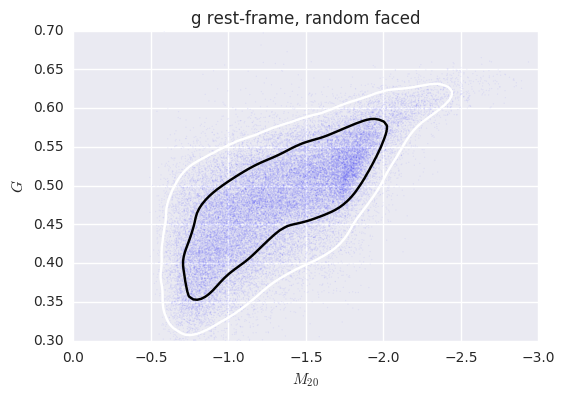

In [15]:
plt.scatter(x, y, alpha=0.05, edgecolor='none', s=1)
plt.contour(X, Y, Z, levels=[s2_dens, s1_dens])

plt.xlim(plt.xlim(-3,0)[::-1])
plt.ylim(.3,.7)
plt.xlabel('$M_{20}$')
plt.ylabel('$G$')
plt.title('g rest-frame, random faced')
plt.savefig('illustris_regiones_confianza.png')

In [1]:
import illustris_python as il

In [2]:
basePath = '../illustris/'

GroupFirstSub = il.groupcat.loadHalos(basePath,135,fields=['GroupFirstSub'])

In [4]:
GroupFirstSub.shape

(7713601,)

In [2]:
fields = ['SubhaloMass','SubhaloSFRinRad']
subhalos = il.groupcat.loadSubhalos(basePath,135,fields=fields)

OSError: Unable to open file (Unable to open file: name = './illustris-3//groups_135/fof_subhalo_tab_135.0.hdf5', errno = 2, error message = 'no such file or directory', flags = 0, o_flags = 0)

In [21]:
import glob
files = glob.glob('../illustris/groups_135.*.hdf5')

In [24]:
groups = h5py.File('../illustris/groups_135.0.hdf5')

In [36]:
for item in groups['Subhalo']:
    print(item)

SubhaloBHMass
SubhaloBHMdot
SubhaloCM
SubhaloGasMetallicity
SubhaloGasMetallicityHalfRad
SubhaloGasMetallicityMaxRad
SubhaloGasMetallicitySfr
SubhaloGasMetallicitySfrWeighted
SubhaloGrNr
SubhaloHalfmassRad
SubhaloHalfmassRadType
SubhaloIDMostbound
SubhaloLen
SubhaloLenType
SubhaloMass
SubhaloMassInHalfRad
SubhaloMassInHalfRadType
SubhaloMassInMaxRad
SubhaloMassInMaxRadType
SubhaloMassInRad
SubhaloMassInRadType
SubhaloMassType
SubhaloParent
SubhaloPos
SubhaloSFR
SubhaloSFRinHalfRad
SubhaloSFRinMaxRad
SubhaloSFRinRad
SubhaloSpin
SubhaloStarMetallicity
SubhaloStarMetallicityHalfRad
SubhaloStarMetallicityMaxRad
SubhaloStellarPhotometrics
SubhaloStellarPhotometricsMassInRad
SubhaloStellarPhotometricsRad
SubhaloVel
SubhaloVelDisp
SubhaloVmax
SubhaloVmaxRad
SubhaloWindMass


In [ ]:
out_csv = csv.writer(open('output_file.csv', 'rb'))

def extract_data_from_filename(filename):
    return extract_data_from_handle(hdf5.File(filename, 'r'))

for filename in files:
  data = extract_data_from_filename(filename)
  for row in data:
     out_csv.writerow((filename, ) +row)

In [ ]:
def plot_g_m20(filtro, orientación, marcador='.'):
    fig, ax = plt.subplots()
    
    df[(df.filtro == filtro) & (df.orientación == orientación)] \
        .plot.scatter(x='m20', y='gini', c='UB', s=5, edgecolor='none', cmap='rainbow', ax=ax, marker=marcador)
    
    if orientación == 'rand': orientación = 'random'
        
    plt.xlim(plt.xlim(-3,0)[::-1])
    plt.ylim(.3,.7)
    plt.xlabel('$M_{20}$')
    plt.ylabel('$G$')
    plt.title('UB magnitude, %s band, %s oriented' % (filtro, orientación))
    plt.savefig('u-b_gini_vs_m20_%s_%s.png' % (filtro, orientación))

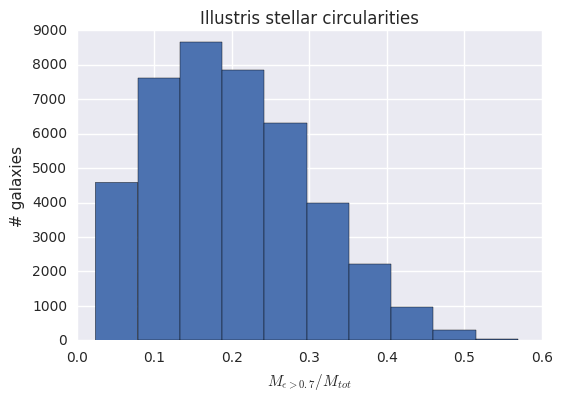

In [96]:
g.e.hist()
plt.title('Illustris stellar circularities')
plt.ylabel('# galaxies')
plt.xlabel('$M_{\epsilon > 0.7}/M_{tot}$')
plt.savefig('illustris_stellar_circularities_histogram.png')

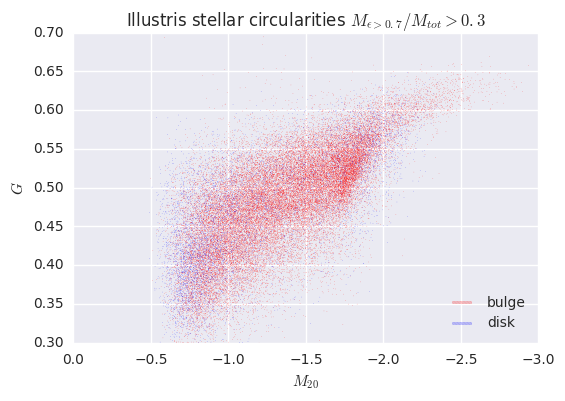

In [95]:
CORTE = .3

gd = g[g.e >  CORTE]
gb = g[g.e <= CORTE]

fig, ax = plt.subplots()

ax.scatter(x=gb.m20_rand, y=gb.gini_rand, c='red',  s=.1, edgecolor='none', label='bulge')
ax.scatter(x=gd.m20_rand, y=gd.gini_rand, c='blue', s=.1, edgecolor='none', label='disk')

ax.legend(loc=4, scatterpoints=100)

plt.xlim(plt.xlim(-3,0)[::-1])
plt.ylim(.3,.7)
plt.xlabel('$M_{20}$')
plt.ylabel('$G$')
plt.title('Illustris stellar circularities $M_{\epsilon > 0.7}/M_{tot} > %s$' % CORTE)
plt.savefig('illustris_bulge_disk.png')

In [48]:
X, y = g[['gini', 'm20', 'concentration', 'petrosian_radius', 'half_light_radius']], g['e']

In [49]:
import sklearn.model_selection

X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X.values, y.values, random_state=1)

### Otras cosas

In [136]:
df.groupby(['filtro', 'cámara'])

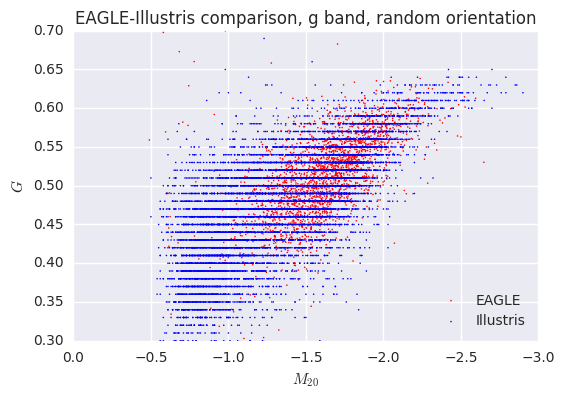

In [103]:
    fig, ax = plt.subplots()
    
    df[(df.filtro == 'g') & (df.orientación == 'rand')] \
        .plot.scatter(x='m20', y='gini', c='r', s=5, edgecolor='none', ax=ax, marker='.', label='EAGLE')
    
    il[(il.filtro == 'gSDSS') & (il.cámara == 'cam0')] \
        .plot.scatter(x='m20', y='gini', c='b', s=5, edgecolor='none', ax=ax, marker='.', label='Illustris')
        
    plt.legend(loc=4)
    plt.xlim(plt.xlim(-3,0)[::-1])
    plt.ylim(.3,.7)
    plt.xlabel('$M_{20}$')
    plt.ylabel('$G$')
    plt.title('EAGLE-Illustris comparison, g band, random orientation')
    plt.savefig('g_random_illustris_eagle_gini_vs_m20.png')

## Registro

Algunos acrónimos

* SED: spectral energy distribution
* SFR: star formation rate
* PSF: point-spread function
* RT: radiative transfer
* ISM: interstellar medium
* SPS: stellar population synthesis

### Publicaciones

* Abraham 2003: antecedente de Lotz 2004 (no es tan importante)
* *Conselice 2003*: definiciones de parámetros
* Lotz 2004: morfologías no paramétricas

**Illustris**

* Schaye 2014: morfologías
* [Snyder 2015](https://arxiv.org/pdf/1502.07747.pdf) — Simulated galaxy morphologies at $z = 0$
* [Torrey 2015](https://arxiv.org/pdf/1411.3717.pdf) — Synthetic galaxy images and spectra from the Illustris simulation
* [Genel 2015](https://arxiv.org/pdf/1503.01117.pdf) — Galactic angular momentum in the Illustris simulation

**EAGLE**

* Trayford 2015: FITS
* Lagos 2017: galactic angular momentum

**Extra**

* A catalog of visual-like morphologies in the 5 CANDELS fields using deep-learning — https://arxiv.org/abs/1509.05429

### Notas

**Bandas**

* u *ultravioleta*
* b *azul*
* g/v *verde/visible*
* r *rojo*
* i *infrarrojo*


### TODO

**De antes**

* ¿Qué hace el código de Lotz con los parámetros de `morph.dat` (como PSF)?
* ~~Invertir eje SRF/M~~
* ~~Arreglar G-M20~~
* ~~r face deberían ser 3625 galaxias~~
* Comparación con g-r de Illustris -> cambio por g-i porque Illustris no tiene la banda r
* EAGLE zoo (clasificación visual)
* Machine learning
* momento angular eagle (paper lagos)
* ~~Gini-M20~~
  * r face
  * g face
  * g rand
* ~~Gini-M20 superpuestos Illustris / EAGLE en g_face~~
* ~~Gini-M20 superpuestos g_face / g_rand~~

**11 de julio**

* Aplicar ML de Illustris a EAGLE
* EAGLE zoo
* Documento Latex
  * Intro
  * Iraf
  * Lotz
  * Gini M20 vs propiedades (EAGLE)
    * Todos los plots que hay
  * ML Illustris
    * Mención de la técnica usada
  * ML de Illustris a EAGLE
  
**15 de julio**

* Gráfico de épsilon sobre G-M20 en Illustris
* Ver qué onda la función F. *En Lotz 2004 no están los parámetros de la recta que separa las galaxias*.
* Ver de calcular el épsilon para EAGLE
* *¿Cuál es la fracción bola-disco en el cielo? Serviría para calibrar mejor el corte de la fracción épsilon > 0.7*

**22 de agosto**

* Es bueno el método de Lotz para clasificar morfológicamente a las galaxias? Eso podemos evaluar comparando la clasificación de ella con la visual y con la dinámica (elipticidad de James). Podríamos si vemos que tiene problemas pensar en usar el método de Lucas. Pero creo que él encontraba un buen acuerdo.

Lo de las curvas de nivel está difícil. No es imposible pero habría que definir un centroide a partir del cual comenzar a acumular galaxias según algún criterio (circular, elíptico, etcétera) hasta cubrir el 68% y el 95% de la población de galaxias.

Esto es para ver el nivel de solapamiento entre galaxias de distinto tipo.

A mi parecer con los datos de las simulaciones el G-M20 si bien muestra una tendencia de separación, es apenas eso y las galaxias se muestran bastante mezcladas.

Esto llevaría a que la simulación está mal o a que el método de Lotz no es completamente aceptable (al parecer lo es).

- G-M20, según $UB > 1$ (rojas) y $UB < 1$ (azules), figura 2 y en menor medida figuras 3 y 4.

  - Azules tienen SFR más alto. 
  - Rojas son galaxias "apagadas".
  - G-M20 segmentado por M∗ muestra tendencias disímiles (figura 6).
  
- *Tendencias morfológicas*, figura 5.

  - SFR versus M∗
  - overdensity versus M∗
  - SSFR versus compactness
  
- *Tendencias cinemáticas*, figuras 7 y 8.

  - (β) twice the fraction of star particles with e < 0
  - specific angular momentum (escala como M^2/3)
  - $κ_{rot}$, the  fraction  of  kinetic  energy  occupied  by ordered  rotational  motion

Versus F, quiescent  fraction (básicamente fracción de galaxias con SSFR menor a cierto umbral), morfología por densidad (que presupone una clasificación; figura 9).

- Discusión
  
  - Alcanza con ajustar las distribuciones para M∗ (stellar mass function) y SFR en $z=0$.
  - Depende de cómo está modelado el feedback (SFR depende de la morfología).
  - Pareciera ser que la clasificación entre disco/bulto aporta poca información.
  
 
  

* Usando algoritmos de machine learning puede conseguirse una mejora en la clasificación? de cuánto?

Seguro que sí pero desde ya se ve que hay que incluir más atributos, dos es poco.

Illustris ofrece valores precalculados de (Gini,M20,C,rP,rE) usando filtros (gSDSS, iSDSS, uSDSS, and hWFC3) en rest-frame para z=0.

* Si el método es bueno, la clasificación debería correlacionar por ejemplo con la SFR y con los colores de las galaxias. O sea, por ej, aquellas galaxias con Gini alto según Lotz deberían ser más rojas y formar menos estrellas. Eso se encuentra?
* Existe algún bias debeido a la orientación random/face-on?
* Existe bias con respecto a la clasificación visual?
* Depende la clasificación del filtro utilizado?
* Comparación con Illustris

https://github.com/zooniverse/Galaxy-Zoo/blob/master/public/locales/es.json

¿Por qué es importante la morfología de las galaxias?"

En primer lugar, la morfología de una galaxia es el rastro de la dinámica orbital de las estrellas que la conforman, pero también lleva consigo la huella de los procesos que conducen la formación estelar y la actividad nuclear en las galaxias. La morfología visual crea clasificaciones que están fuertemente relacionadas con parámetros físicos. Para dar un ejemplo simple, la presencia de múltiples núcleos y características de amplios escombros, indica que el mecanismo dominante que conlleva a la formación estelar es una fusión en proceso. De igual manera, la ausencia de dichas características implica que la evolución de la galaxia podría estar siendo impulsada por procesos internos ('secular').

"reference": "Tradicionalmente, la morfología se ha derivado ya sea en la inspección visual de imágenes de galaxias o vía parámetros morfológicos como la concentración, asimetría, agrupamiento, M20, el coeficiente de Gini, etc. En estricto rigor, estos parámetros son 'representantes' morfológicos, cada uno con sus respectivos prejuicios contaminantes, que comúnmente son verificados y ajustados mediante inspección visual. Una aproximación visual es generalmente más resistente al cambio de señal a ruido y resolución en las imágenes, convirtiéndolo en un método ideal a la hora de determinar la morfología de las galaxias. Sin embargo, parámetros morfológicos han sido de gran valor a la hora de clasificar grandes conjuntos de datos a escala de exploraciones, en los que la inspección visual realizada por individuos (o pequeños grupos de investigadores) significaría un altísimo y demandante consumo de tiempo.

https://jscholarship.library.jhu.edu/bitstream/handle/1774.2/40300/PETH-DISSERTATION-2016.pdf?sequence=1&isAllowed=y

https://github.com/vrodgom/statmorph